2017

Machine Learning Practical

University of Edinburgh

Georgios Pligoropoulos - s1687568

Coursework 4 (part 1a)

### Imports, Inits, and helper functions

In [18]:
import sys, os
mlpdir = os.path.expanduser(
    '~/pligor.george@gmail.com/msc_Artificial_Intelligence/mlp_Machine_Learning_Practical/mlpractical'
)
sys.path.append(mlpdir)

In [19]:
jupyterNotebookEnabled = True
plotting = True

if jupyterNotebookEnabled:
    %matplotlib inline

In [54]:
coursework, part = 4, "1a"
saving = True

In [21]:
import pickle
import skopt
from skopt.plots import plot_convergence
from mylibs.jupyter_notebook_helper import show_graph
import datetime
import os
import time
import tensorflow as tf
import numpy as np
from mlp.data_providers import MSD10GenreDataProvider, MSD25GenreDataProvider,\
    MSD10Genre_Autoencoder_DataProvider, MSD10Genre_StackedAutoEncoderDataProvider
import matplotlib.pyplot as plt

from mylibs.batch_norm import fully_connected_layer_with_batch_norm_and_l2
from mylibs.stacked_autoencoder_pretrainer import \
    constructModelFromPretrainedByAutoEncoderStack,\
    buildGraphOfStackedAutoencoder, executeNonLinearAutoencoder
    
from mylibs.jupyter_notebook_helper import getRunTime, getTrainWriter, getValidWriter,\
    plotStats, initStats, gatherStats
    
from mylibs.tf_helper import tfRMSE, tfMSE, fully_connected_layer,validateEpoch
    #trainEpoch, 

from mylibs.py_helper import merge_dicts

from mylibs.batch_norm import batchNormWrapper_byExponentialMovingAvg,\
    fully_connected_layer_with_batch_norm
    
from mylibs.dropout_helper import constructProbs

from skopt.space.space import Real
from skopt import gp_minimize

In [22]:
seed = 16011984
rng = np.random.RandomState(seed=seed)

In [23]:
config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [24]:
figcount = 0

In [25]:
tensorboardLogdir = 'tf_cw{}_{}'.format(coursework, part)
tensorboardLogdir

'tf_cw4_1a'

In [26]:
curDtype = tf.float32

In [27]:
reluBias = 0.1

In [28]:
batch_size = 50

In [29]:
total_songs = 40000

### Pretraining if necessary

In [30]:
hidden_dims = np.array([500, 500, 25, 10]).astype(int)
hidden_dims

array([500, 500,  25,  10])

In [31]:
pretrainedModelVarsFilename = 'pretrainedModelVars_base_model_cw4.npz'

if os.path.isfile(pretrainedModelVarsFilename):
    modelVars = np.load(pretrainedModelVarsFilename)
    modelVars = modelVars[modelVars.keys()[0]]
    
else:
    modelVars = constructModelFromPretrainedByAutoEncoderStack(hidden_dims,
                                                               autoencoder= executeNonLinearAutoencoder,
                                                               rng=rng,
                                                               config=config,
                                                               dataProviderClass= MSD10Genre_StackedAutoEncoderDataProvider)
    np.savez(pretrainedModelVarsFilename, modelVars)

### MSD 10 genre task

In [32]:
#re-initialize the random state in order to get eventually the same order of songs at the
#end of the epochs, the _current_order attribute keeps the order of the songs
rng = np.random.RandomState(seed=seed)
train_data = MSD10GenreDataProvider('train', batch_size=batch_size, rng=rng)
#((50, 3000), (50, 10))
valid_data = MSD10GenreDataProvider('valid', batch_size=batch_size, rng=rng)

In [33]:
#tf.reset_default_graph() #kind of redundant statement
isPretrained = True
learningRate = 1e-4 #default of Adam is 1e-3
#learningRate = 1e-3 #default of Adam is 1e-3
#momentum = 0.5
lamda2 = 1e-2

graph = tf.Graph() #create new graph

hidden_layers = []
regularizers = []
keep_probs = []

with graph.as_default():
    with tf.name_scope('data'):
        inputs = tf.placeholder(curDtype, [batch_size, train_data.inputs.shape[1]], 'inputs')
        targets = tf.placeholder(curDtype, [batch_size, train_data.num_classes], 'targets')
    
    with tf.name_scope('params'):
        training = tf.placeholder(tf.bool, name="training")
        
    with tf.name_scope("dropout0"):
        keep_probs.append(tf.placeholder(tf.float32))
        inputs_prob = tf.nn.dropout(inputs, keep_probs[0])
    
    with tf.name_scope('fullyConnected0'):
        curLayer, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(
            0, inputs_prob,
            train_data.inputs.shape[1], hidden_dims[0],
            nonlinearity= tf.nn.tanh,
            w = modelVars[0][0] if isPretrained else None,
            b = modelVars[0][1] if isPretrained else None,
            training=training,
            lamda2 = lamda2
        )
        
        hidden_layers.append(curLayer)
        regularizers.append(curRegularizer)
    
    
    for i in range(1, len(hidden_dims)-1):
        with tf.name_scope("dropout%d" % i):
            keep_probs.append(tf.placeholder(tf.float32))
            cur_hidden_layer_prob = tf.nn.dropout(hidden_layers[i-1], keep_probs[i])
        
        with tf.name_scope('fullyConnected%d' % i):
            curLayer, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(i,
                                  cur_hidden_layer_prob,
                                  hidden_dims[i-1], hidden_dims[i],
                                  nonlinearity = tf.nn.tanh,
                                  w = modelVars[i][0] if isPretrained else None,
                                  b = modelVars[i][1] if isPretrained else None,
                                  training = training,
                                  lamda2 = lamda2)
            
            hidden_layers.append(curLayer)
            regularizers.append(curRegularizer)

    
    finalIndex = len(hidden_dims)-1
    
    with tf.name_scope("dropout%d" % finalIndex):
        keep_probs.append(tf.placeholder(tf.float32))
        final_hidden_layer_prob = tf.nn.dropout(hidden_layers[finalIndex-1], keep_probs[finalIndex])

    with tf.name_scope('readout_output_layer'):
        outputs, curRegularizer = fully_connected_layer_with_batch_norm_and_l2(finalIndex,
            final_hidden_layer_prob,
            hidden_dims[finalIndex-1], train_data.num_classes,
            training=training,
            nonlinearity=tf.identity,
            w = modelVars[finalIndex][0] if isPretrained else None,
            b = modelVars[finalIndex][1] if isPretrained else None,
            lamda2 = lamda2
        )

        regularizers.append(curRegularizer)

    with tf.name_scope('error'):
        #smaller cross entropy is better
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(outputs, targets) #(50, )
        error = tf.reduce_mean(cross_entropy) #() <-- scalar value
        
        for reg in regularizers:
            error += reg

    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1),
                                                   tf.argmax(targets, 1)), dtype=curDtype))

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(error)
#         train_step = tf.train.RMSPropOptimizer(
#             learning_rate=learningRate,
#             momentum=momentum
#         ).minimize(error)

    init = tf.global_variables_initializer()
    
if not isPretrained: #sorry it crashes otherwise
    show_graph(graph)

In [34]:
def trainEpoch(inputs, targets, sess, e, train_data, train_step, error, accuracy, extraFeedDict):
    train_error = 0.
    train_accuracy = 0.
    
    num_batches = train_data.num_batches
    
    cross_entropies = np.zeros(total_songs)
    
    for step, (input_batch, target_batch) in enumerate(train_data):
        batch_cross_entr, _, batch_error, batch_acc = sess.run(
            [cross_entropy, train_step, error, accuracy], 
            feed_dict= merge_dicts({inputs: input_batch, targets: target_batch}, extraFeedDict)
        )
        #print batch_cross_entr
        #time.sleep(10)
        #we are only keeping the last one
        
#         (0, 50)
#         (50, 100)
#         (100, 150)
        inds = train_data._current_order[step * batch_size : (step+1)*batch_size]
        cross_entropies[inds] = batch_cross_entr
        
        train_error += batch_error
        train_accuracy += batch_acc
    
    train_error /= num_batches
    
    train_accuracy /= num_batches
    
    return train_error, train_accuracy, cross_entropies

In [35]:
def trainAndValidate(input_keep_prob=0.9, hidden_keep_prob=0.7, epochs=35, verbose=True):
    if verbose:
        print "epochs: %d" % epochs
        print "input_keep_prob: %f" % input_keep_prob
        print "hidden_keep_prob: %f" % hidden_keep_prob
    
    keep_prob_dict = constructProbs(keep_probs,
                                    cur_input_prob=input_keep_prob,
                                    cur_hidden_prob=hidden_keep_prob)

    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init)

        stats, keys = initStats(epochs)
        
        #this is going to be overwritten multiple times, it is ok
        #the intention is to keep only the last one
        cross_entropies = None

        for e in range(epochs):
            (train_error, train_accuracy, cross_entropies), runTime = getRunTime(lambda : 
                    trainEpoch(
                        inputs, targets, sess, e, train_data, train_step, error, accuracy,
                        extraFeedDict = merge_dicts(keep_prob_dict, {training: True})
                )
            )

            #print 'End epoch %02d (%.3f secs): err(train)=%.2f acc(train)=%.2f' % (e+1, runTime, train_error,train_accuracy)

            if (e + 1) % 1 == 0:
                valid_error, valid_accuracy = validateEpoch(
                    inputs, targets, sess, e, valid_data, error, accuracy,
                    extraFeedDict = {training: False}, keep_prob_keys=keep_probs
                )

                #print((' ' * 27) + 'err(valid)={0:.2f} acc(valid)={1:.2f}'.format(valid_error, valid_accuracy))

            if verbose:
                print 'End epoch %02d (%.3f secs): err(train)=%.2f, acc(train)=%.2f, err(valid)=%.2f, acc(valid)=%.2f, ' %\
                    (e+1, runTime, train_error, train_accuracy, valid_error, valid_accuracy)

            stats = gatherStats(e, train_error, train_accuracy,
                                valid_error, valid_accuracy, stats)
    
    if verbose:
        print
    
    return stats, keys, cross_entropies

In [37]:
best_probs_base_classifier_filename = 'best_probs_base_classifier.npy'
best_probs_base_classifier = np.load(best_probs_base_classifier_filename)
best_probs_base_classifier

array([ 0.7       ,  0.83712466])

In [38]:
cross_entropies_filename = 'cross_entropies_base_classifier.npy'

In [39]:
%%time

if os.path.isfile(cross_entropies_filename):
    cross_entropies = np.load(cross_entropies_filename)
else:
    input_keep_prob, hidden_keep_prob = best_probs_base_classifier

    print best_probs_base_classifier

    stats, keys, cross_entropies = trainAndValidate(epochs=100,
        input_keep_prob=input_keep_prob,
        hidden_keep_prob=hidden_keep_prob
    )

    if plotting:
        fig_1, ax_1, fig_2, ax_2 = plotStats(stats, keys)
        figcount += 1

    np.save(cross_entropies_filename, cross_entropies)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.6 ms


In [46]:
np.argsort(cross_entropies)[:10]

array([36530, 22504, 23923, 14754, 36193,  5299,  8800,  7080, 23828, 21521])

In [45]:
np.sort(cross_entropies)[:10]

array([ 0.00018655,  0.00040487,  0.00047792,  0.00050687,  0.00051187,
        0.00063399,  0.00075622,  0.00076277,  0.00079064,  0.00084424])

In [47]:
np.argsort(cross_entropies)[-10:]

array([ 4277, 20715, 10365, 21103, 35860, 19281, 33962, 22192, 17289, 22241])

In [48]:
np.sort(cross_entropies)[-10:]

array([ 6.81745005,  6.82365227,  7.14912271,  7.1554656 ,  7.25000525,
        7.38539267,  7.66791773,  8.00147915,  8.09997749,  9.0351572 ])

In [49]:
np.mean(cross_entropies)

0.7685535595076799

In [50]:
np.var(cross_entropies)

0.96230627796890367

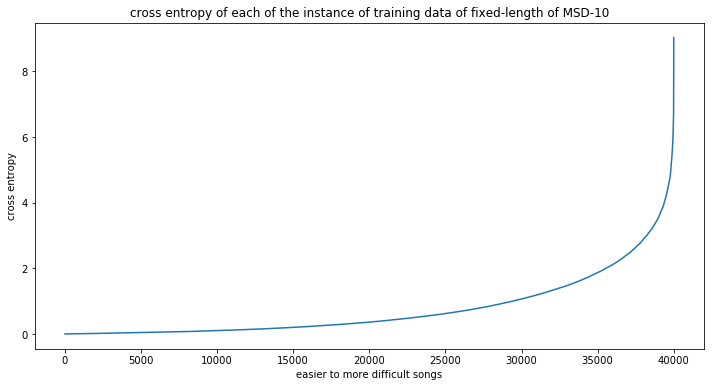

In [56]:
if plotting:
    fig = plt.figure(figsize=(12,6))
    plt.plot(np.sort(cross_entropies))
    plt.xlabel('easier to more difficult songs')
    plt.ylabel('cross entropy')
    plt.title('cross entropy of each of the instance of training data of fixed-length of MSD-10')
    plt.show()
    if saving:
        fig.savefig('cw{}_part{}_{:02d}_fig.svg'.format(coursework, part, figcount))